In [19]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import numpy as np
# import torch
# import torchvision
import matplotlib.pyplot as plt
from time import time
# from torchvision import datasets, transforms
# from torch import nn, optim
import random
random_state = 10 # Ensure reproducible results
%matplotlib inline

In [3]:
def masking_data (data):
    masked_data = data.copy()
    y = []
    for i in range(len(data)):
        indexs = np.where(masked_data[i]==1)[0]
        random_index = random.randint(0,len(indexs)-1)
        masked_data[i][indexs[random_index]] = 0
        y.append(indexs[random_index])
    return masked_data,y

In [22]:
testbed_mat = loadmat('Queries/suggestion_testbed.mat')
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
ing_headline.append('label')
dataset_X,dataset_y = masking_data(recipe_mat)
dataset_X = np.concatenate([dataset_X,labels_mat],axis=1)
dataset_X = pd.DataFrame(dataset_X,columns=ing_headline)
dataset_y = pd.DataFrame(dataset_y,columns=['label'])
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25)

In [5]:
X_train.iloc[:,:-1].sum()

acorn squash                      1
adobo                             3
african birdseye chile pepper     3
ale                               3
aleppo pepper                     1
                                 ..
yellow squash                     4
yogurt                           76
zaatar                            1
zest                             11
zucchini                         71
Length: 709, dtype: int64

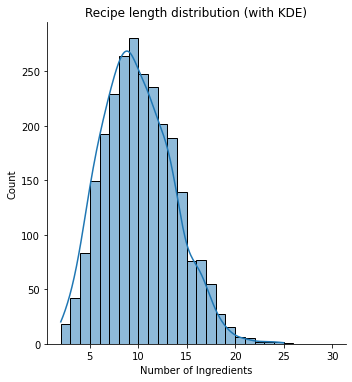

In [6]:
## -- Plot number of ingredients
ax = sns.displot(np.sum(X_train.iloc[:,:-1],axis=1), bins=np.linspace(1,29,29)+1,kde=True)
ax.set(xlabel="Number of Ingredients", title="Recipe length distribution (with KDE)")

<AxesSubplot:title={'center':'Top 20 ingredients'}>

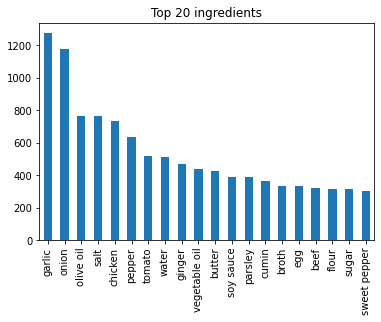

In [7]:
#--- top 10 most used ingredients
fig, ax = plt.subplots()
# sum up occurences of each ingredient
freq_ing = X_train.iloc[:,:-1].sum()
# filter for the 10 most frequent
most_freq_ing = freq_ing.nlargest(20)
ax.set_title("Top 20 ingredients")
most_freq_ing.plot.bar()

In [8]:
X_train_sc = StandardScaler().fit_transform(X_train)

In [9]:
X_train_sc

array([[-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333,  0.70706692],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -0.15740319],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.0218733 ],
       ...,
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.59818671],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.59818671],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -0.7337166 ]])

In [10]:
def scatter_2d_label(X_2d, y, ax=None, s=2, alpha=0.5, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

def kde_2d_label(X_2d, y, ax=None):
    """Kernel density estimate in a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Data to plot
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on    
    """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    targets = np.unique(y)
    palette_name = 'bright'
    colors = sns.color_palette(palette_name, n_colors=targets.size)
    lines = []
    for color, target in zip(colors, targets):
        sns.kdeplot(X_2d[y==target, 0], X_2d[y==target, 1], ax=ax, cmap=sns.dark_palette(color, as_cmap=True))
        lines.append(mlines.Line2D([], [], color=color, label=target))  # dummy line for the legend
    
    # add legend
    ax.legend(lines, targets, loc='center left', bbox_to_anchor=[1.01, 0.5], frameon=False) 
    

In [11]:
X_train_sc

array([[-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333,  0.70706692],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -0.15740319],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.0218733 ],
       ...,
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.59818671],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -1.59818671],
       [-0.01984189, -0.03438071, -0.03438071, ..., -0.06593805,
        -0.16954333, -0.7337166 ]])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

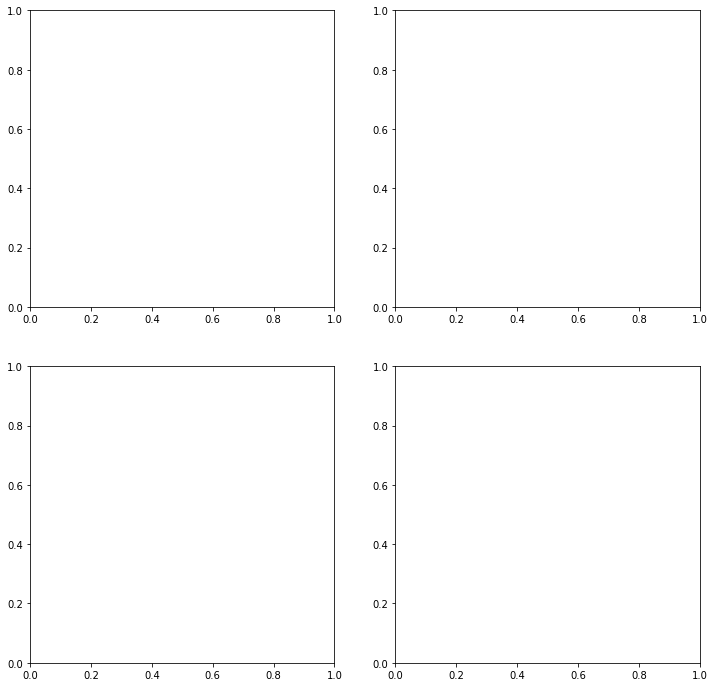

In [12]:
from sklearn.decomposition import KernelPCA

# Your code goes here

kernels = ['poly', 'rbf', 'cosine', 'sigmoid']
fig, ax = plt.subplots(2,2,figsize=(12,12));

for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel).fit_transform(X_train_sc)
    cur_ax = ax[ii//2, ii%2]
    scatter_2d_label(X_kpca_2d, y_train, ax=cur_ax)
    cur_ax.set(title='{} kernel'.format(kernel))
    cur_ax.legend().set_visible(False)

ax[0, 0].set_ylabel('Principal component 2')
ax[1, 0].set_ylabel('Principal component 2')

ax[1, 0].set_xlabel('Principal component 1')
ax[1, 1].set_xlabel('Principal component 1')

plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3);

In [13]:
def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt = '.2f'
    
    # Your code goes here
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Your code goes here

def dummy_pipe(X_train, y_train, dummy_strategy):
    
    # dummy classifier
    dclf = DummyClassifier(strategy=dummy_strategy)
    
    # construct the pipeline
#     pipe = Pipeline([('scaler', StandardScaler()), ('dclf', dclf)])
    pipe = Pipeline([('dclf', dclf)])
    # train
    pipe.fit(X_train, y_train)  # we do not need the _sc variable

    return pipe

pipe_mf = dummy_pipe(X_train, y_train, 'most_frequent')
val_score_mf = pipe_mf.score(X_val, y_val)

# Note: since labels are guessed randomly, different runs give different results
pipe_strat = dummy_pipe(X_train, y_train, 'stratified')  
val_score_strat = pipe_strat.score(X_val, y_val)

#
pipe_prior = dummy_pipe(X_train, y_train, 'prior')
val_score_prior = pipe_mf.score(X_val, y_val)

pipe_uni = dummy_pipe(X_train, y_train,'uniform')
val_score_uni = pipe_mf.score(X_val, y_val)


print("Classification accuracy on the validation set:")
print("'Most-frequent' dummy classifier: {0:.3f}".format(val_score_mf))
print("'Stratified' dummy classifier: {0:.3f}".format(val_score_strat))
print("'prior' dummy classifier: {0:.3f}".format(val_score_prior))
print("'uniform' dummy classifier: {0:.3f}".format(val_score_uni))


Classification accuracy on the validation set:
'Most-frequent' dummy classifier: 0.050
'Stratified' dummy classifier: 0.009
'prior' dummy classifier: 0.050
'uniform' dummy classifier: 0.050


In [14]:
# standardisation
# sc = StandardScaler().fit(X_train)
# X_train_sc = sc.transform(X_train)
# X_val_sc = sc.transform(X_val)
# X_test_sc = sc.transform(X_test)  # needed below
X_train_sc = X_train
X_val_sc = X_val
names = ["Dummy, most frequent", "Gaussian Naive Bayes", "Logistic Regression",
         "Nearest Neighb (10)", "Nearest Neighb (5)",
         "Linear SVM", "RBF SVM",
         "Random Forest", "MLP", "MLP stronger reg", "LDA", "QDA"]
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    GaussianNB(),
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=5), 
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(random_state=random_state, max_iter=800),  # default regularisation
    MLPClassifier(random_state=random_state, max_iter=800, alpha=1),  # more regularisation
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_train_sc, y_train)
    
    ca_train_score[name] = clf.score(X_train_sc, y_train)
    ce_train_score[name] = log_loss(y_train, clf.predict_proba(X_train_sc))
    
    ca_val_score[name] = clf.score(X_val_sc, y_val)
    ce_val_score[name] = log_loss(y_val, clf.predict_proba(X_val_sc))


print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

ValueError: y_true and y_pred contain different number of classes 220, 350. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [  5   8  16  17  19  34  36  39  46  48  52  53  55  60  61  64  69  73
  78  79  81  85  88  90  91  94  99 102 108 110 111 112 113 114 118 119
 121 122 128 133 134 136 138 140 141 142 143 145 146 147 153 155 156 158
 159 160 163 166 168 172 174 176 182 184 189 192 195 196 200 201 202 203
 204 205 210 212 213 214 216 219 223 237 238 242 245 250 251 254 260 261
 264 265 268 269 275 291 304 305 311 312 318 319 331 333 342 344 345 348
 351 353 354 355 357 358 359 361 374 376 383 385 388 393 394 403 406 408
 410 411 416 420 421 422 425 426 428 438 440 441 442 444 445 448 449 450
 451 458 466 470 472 488 489 490 496 498 510 513 519 521 524 528 529 530
 533 535 540 541 542 543 545 550 551 562 563 564 565 567 568 572 577 578
 579 584 586 598 602 609 614 615 617 620 621 626 635 637 640 642 644 645
 647 651 653 654 664 667 670 671 672 676 677 678 680 683 685 687 688 694
 695 697 705 708]

In [15]:
dataset_full

NameError: name 'dataset_full' is not defined

In [16]:
# pick random forest
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_full, y_train_full)
ca_rf_test = clf.score(X_test, y_test)
ce_rf_test = log_loss(y_test, clf.predict_proba(X_test))

print("Performance on the test set")
print("Classification accuracy:", ca_rf_test)
print("Log-loss:", ce_rf_test)

/Users/Ming/miniconda2/envs/monitor/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


KeyboardInterrupt: 

In [17]:
X_train

,acorn squash,adobo,african birdseye chile pepper,ale,aleppo pepper,alfalfa sprouts,alfredo sauce,allspice,almond,almond butter,...,yeast,yellow curry paste,yellow food coloring,yellow split pea,yellow squash,yogurt,zaatar,zest,zucchini,label
2961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6
757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3221,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
# pytorch mlp for multiclass classification
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torch.nn
# Hyper parameters

dataset_full = np.concatenate((recipe_mat,labels_mat),axis=1)
train_dataset,test_dataset = train_test_split(dataset_full,test_size=0.2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Hyper parameters
num_epochs = 5
num_classes = 12
batch_size = 50
learning_rate = 0.001
num_feature = 709
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        print (x)
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x



In [55]:
model = MulticlassClassification(num_feature,num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, d in enumerate(train_loader):
        images = d[:,:-1]
        labels = d[:,-1]
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for d in test_loader:
        images = d[:,:-1]
        labels = d[:,-1]
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)


RuntimeError: expected scalar type Float but found Byte

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [109]:
dataset_full = np.concatenate((recipe_mat,labels_mat),axis=1)
train_dataset,X_test = train_test_split(dataset_full,test_size=0.2)
X_train,X_val = train_test_split(train_dataset,test_size=0.2)
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])
ing_headline.append('label')
X_train = pd.DataFrame(X_train,columns=ing_headline)
X_val = pd.DataFrame(X_val,columns=ing_headline)
X_test = pd.DataFrame(X_test,columns=ing_headline)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()



In [110]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(X_train[:,:-1], X_train[-1])
val_dataset = ClassifierDataset(X_val[:,:-1], X_train[-1])
test_dataset = ClassifierDataset(X_test[:,:-1], X_test[-1])


In [111]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [112]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = 709
NUM_CLASSES = 12

In [113]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [114]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [116]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=709, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [117]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [118]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [119]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')



Begin training.


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [43]:
dataset_full = np.concatenate((recipe_mat,labels_mat),axis=1)
train_dataset,test_dataset = train_test_split(dataset_full,test_size=0.2)